In [1]:
import json
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import matplotlib
colors = matplotlib.rcParams['axes.prop_cycle'].by_key()['color']

from sklearn.metrics import average_precision_score, precision_recall_curve, auc, roc_curve

import sys
sys.path.append('..')
from lib import *
from numba import njit

plt.style.use('../peptidome.mplstyle')

Code for maxent model (not currently used)

def maxent_load(path):
    arr = np.load(path)
    hi = arr['hi']
    Jij = arr['Jij']
    @njit
    def energy(x): 
        return energy_potts(x, hi, Jij)
    loglikelihood = lambda seq: energy(map_aatonumber(seq))
    return loglikelihood
loglikelihood_human = maxent_load('../maxent/data/Human_9.npz')
loglikelihood_pathogen = maxent_load('../maxent/data/Malaria_9.npz')

In [2]:
# excess factor of self peptides
negative_excess = 10

In [3]:
all_data = {}
for i, pathogen in enumerate(['CMV', 'Malaria']):
    arr = np.load('data/%s.npz'%pathogen)
    data = {}
    
    logp_hh, logp_pp, logp_hp, logp_ph = arr['logp_hh'], arr['logp_pp'], arr['logp_hp'], arr['logp_ph']
    data['logp_hh'], data['logp_pp'], data['logp_hp'], data['logp_ph'] = logp_hh, logp_pp, logp_hp, logp_ph
    
    positive = (logp_ph-logp_pp)
    negative = (logp_hh-logp_hp)[np.random.randint(len(logp_hh), size=len(positive)*negative_excess)]
    y_true = np.concatenate([np.ones(len(positive)), np.zeros(len(negative))])
    y_score = -np.concatenate([positive, negative])
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    
    data['fpr'], data['tpr'], data['roc_auc'] = fpr, tpr, roc_auc
    
    #N = int(1e5)
    #negative = (logp_hh-logp_hp)[np.random.randint(len(logp_hh), size=10*N)]
    #positive = (logp_ph-logp_pp)[np.random.randint(len(logp_ph), size=N)]
    #y_true = np.concatenate([np.ones(len(positive)), np.zeros(len(negative))])
    #y_score = -np.concatenate([positive, negative])
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_score)
    average_precision = average_precision_score(y_true, y_score)

    data['precision'], data['recall'], data['average_precision'] = precision, recall, average_precision

    all_data[pathogen] = data

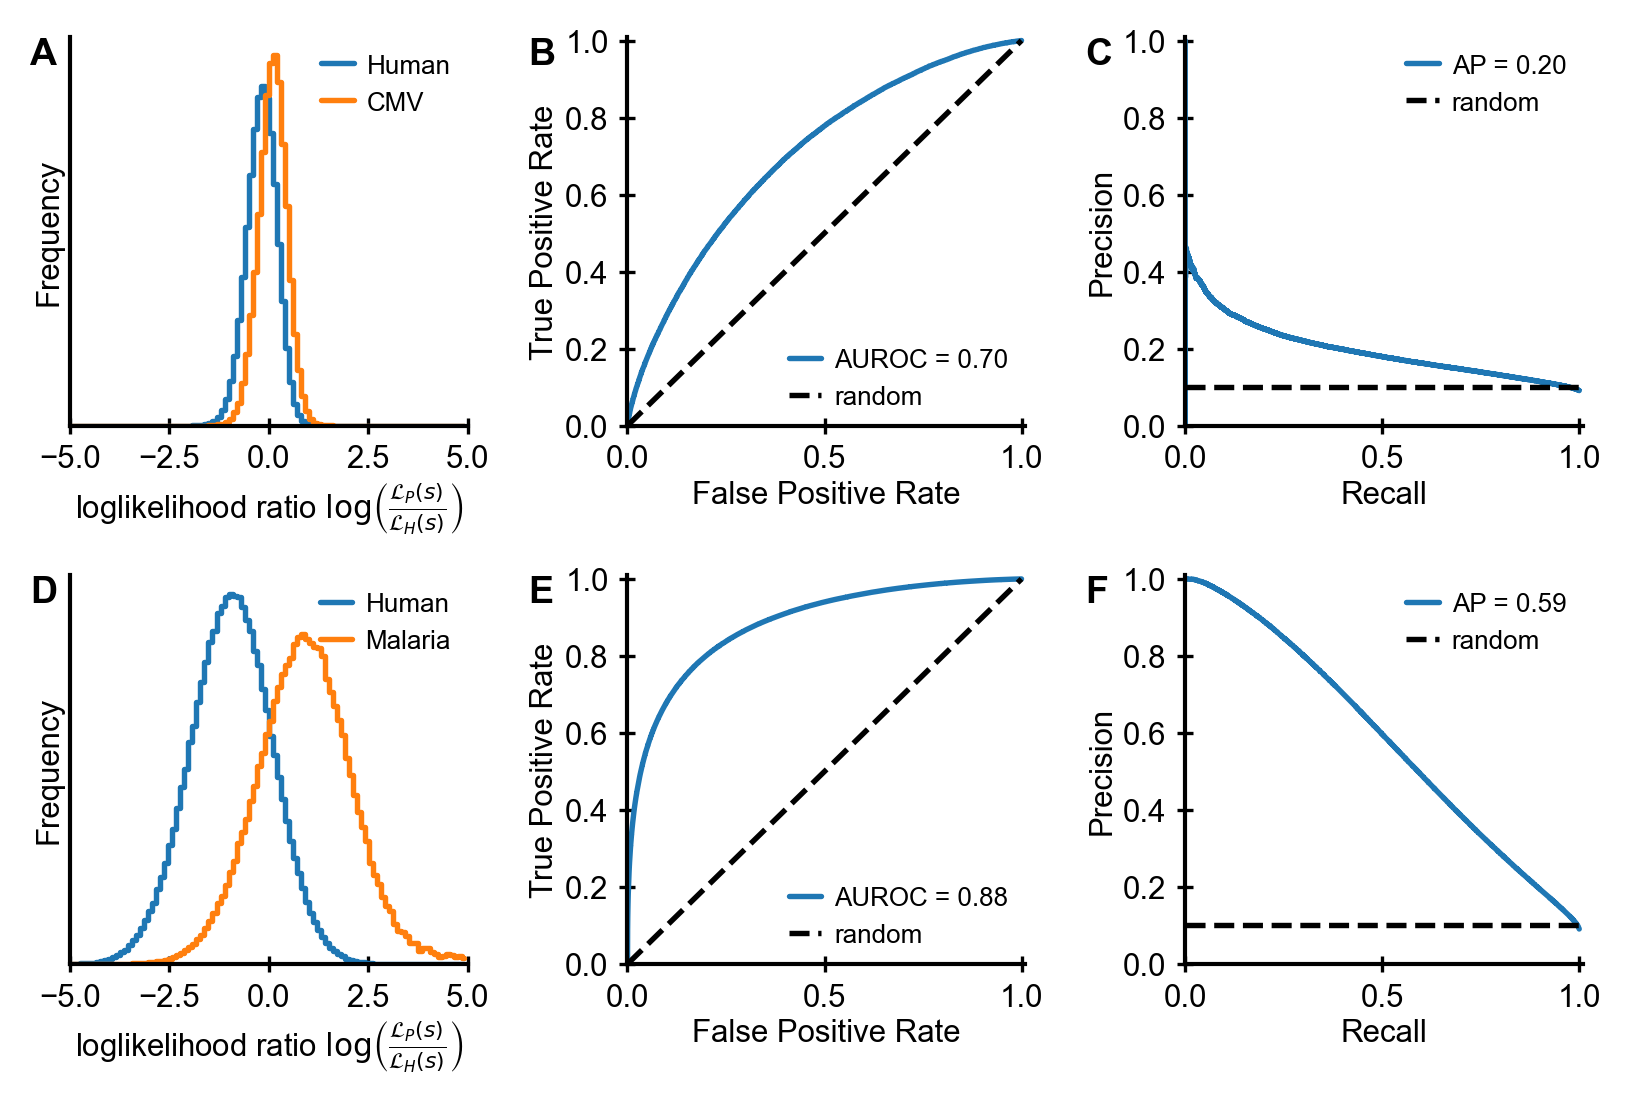

In [4]:
fig, axes = plt.subplots(figsize=(5.5, 3.75), ncols=3, nrows=2)

for i, pathogen in enumerate(['CMV', 'Malaria']):
    
    data = all_data[pathogen]
    logp_hh, logp_pp, logp_hp, logp_ph = data['logp_hh'], data['logp_pp'], data['logp_hp'], data['logp_ph']
    
    ax = axes[i, 0]
    plot_histograms([logp_hp-logp_hh, logp_pp-logp_ph], ['Human', pathogen], xmin=-5, xmax=5, ax=ax, nbins=100)
    ax.set_xlabel(r'loglikelihood ratio $\log \left( \frac{\mathcal{L}_P(s)}{\mathcal{L}_H(s)} \right)$')
    ax.set_yticks([])
    ax.set_ylabel('Frequency')
    ax.set_xlim(-5, 5)
    ax.set_ylim(0.0)
    ax.legend(loc='upper right')

    ax = axes[i, 1]
    ax.plot(data['fpr'], data['tpr'], label='AUROC = %0.2f' % data['roc_auc'])
    ax.plot([0, 1], [0, 1], color='k', linestyle='--', label='random')
    ax.set_xlim(0.0, 1.01)
    ax.set_ylim(0.0, 1.01)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    
    ax = axes[i, 2]
    #ax.plot(recall, 1-precision)
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    #ax.set_ylim(1e-5)
    #ax.set_xlim(1e-5)
    #ax.set_ylabel('1-precision')
    ax.plot(data['recall'], data['precision'], label='AP = {0:0.2f}'.format(data['average_precision']))
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    ax.axhline(1.0/negative_excess, c='k', ls='--', label='random')
    ax.set_ylim(0.0, 1.01)
    ax.set_xlim(0.0, 1.01)
    ax.legend(loc='upper right')

label_axes(axes[:, 0].flatten(), xy=(-0.1, 1.0), labels='AD')
label_axes(axes[:, 1:].flatten(), xy=(-0.25, 1.0), labels='BCEF')
fig.tight_layout()
fig.savefig('main.png')

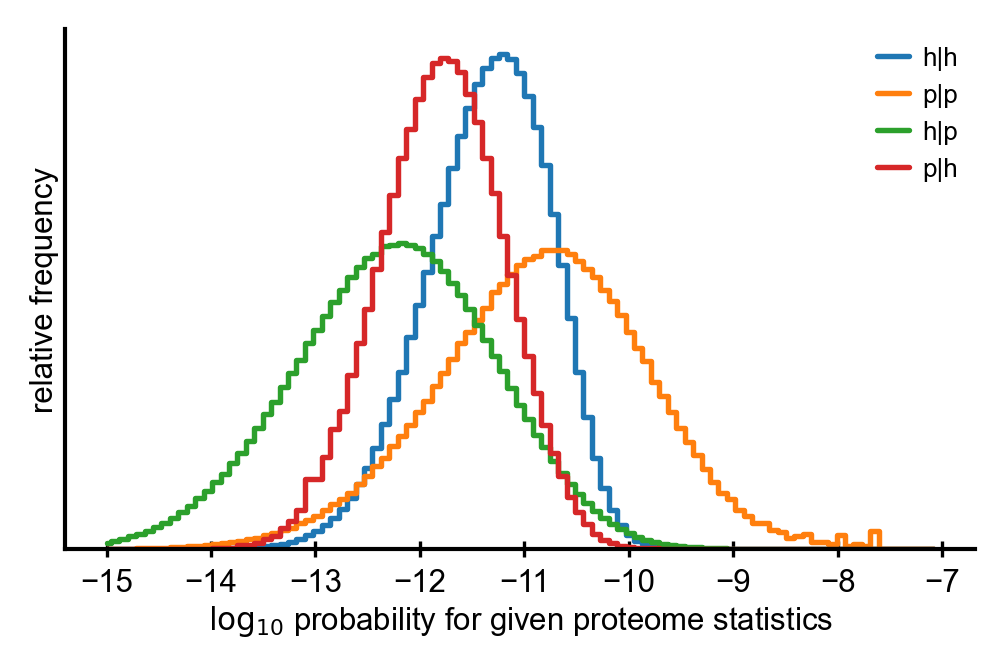

In [5]:
fig, ax = plt.subplots()
plot_histograms([logp_hh, logp_pp, logp_hp, logp_ph],
                ['h|h', 'p|p', 'h|p', 'p|h'],
                nbins=100,
                xmin=-15, xmax=-7, ax=ax)
ax.set_yticks([])
ax.set_ylim(0.0)
ax.set_ylabel('relative frequency')
ax.set_xlabel('$\log_{10}$ probability for given proteome statistics')
fig.tight_layout()

# Overlap statistics

In [6]:
k = 9
counter_cmv = count_kmers_proteome(proteome_path('CMV'), k, clean=True)
counter_human = count_kmers_proteome(proteome_path('Human'), k, clean=True)
counter_malaria = count_kmers_proteome(proteome_path('Malaria'), k, clean=True) 

In [7]:
set_cmv = set(counter_cmv)
set_human = set(counter_human)
set_malaria = set(counter_malaria)

In [8]:
len(set_cmv), len(set_cmv.intersection(set_human))

(63038, 124)

In [9]:
len(set_malaria), len(set_malaria.intersection(set_human))

(3811082, 12175)

In [10]:
def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    print(m)
    if m == str(1):
        print(m)
        return r'10^{{{e:d}}}'.format(e=int(e))
    return r'{m:s}\cdot 10^{{{e:d}}}'.format(m=m, e=int(e))

4
1
1
1
1


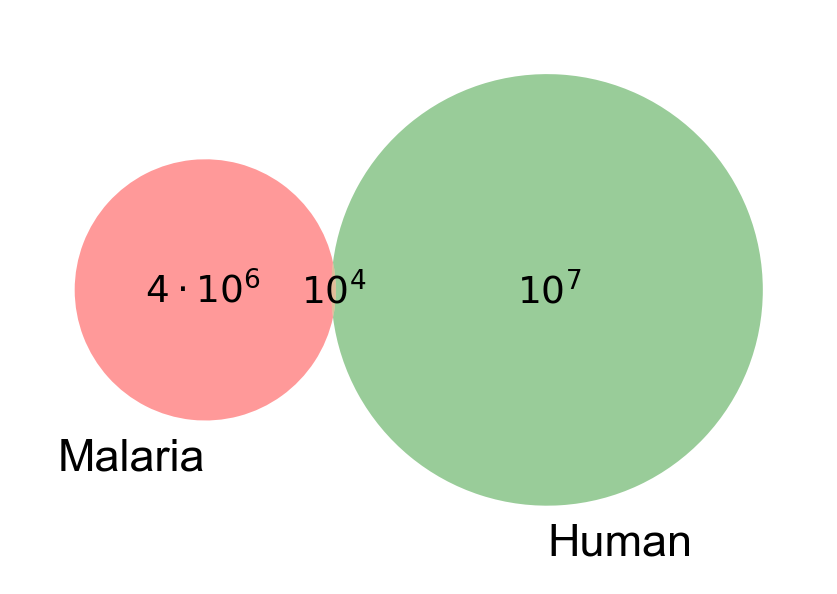

In [11]:
venn2([set_malaria, set_human], set_labels=['Malaria', 'Human'],
      subset_label_formatter=lambda s: '${:s}$'.format(as_si(s, ndp=0)))

In [12]:
len(set_malaria-set_human)/len(set_malaria)

0.9968053691838695

In [13]:
ks = np.arange(1, 11)
fractions_malaria = []
fractions_cmv = []
for k in ks:
    counter_cmv = count_kmers_proteome(proteome_path('CMV'), k, clean=True)
    counter_human = count_kmers_proteome(proteome_path('Human'), k, clean=True)
    counter_malaria = count_kmers_proteome(proteome_path('Malaria'), k, clean=True)
    set_cmv = set(counter_cmv)
    set_human = set(counter_human)
    set_malaria = set(counter_malaria)
    fraction_malaria = len(set_malaria-set_human)/len(set_malaria)
    fraction_cmv = len(set_cmv-set_human)/len(set_cmv)
    print(k, fraction_malaria, fraction_cmv)
    fractions_malaria.append(fraction_malaria)
    fractions_cmv.append(fraction_cmv)

1 0.0 0.0
2 0.0 0.0
3 0.0 0.0
4 0.0007284598470234322 0.00023087756562694802
5 0.1480451532861014 0.0838802599060541
6 0.7695235600679351 0.6651744756240311
7 0.9728197450558965 0.9528276559119407
8 0.9941269035923831 0.9927374566858119
9 0.9968053691838695 0.9980329325168946
10 0.9977029274241407 0.999125025851509


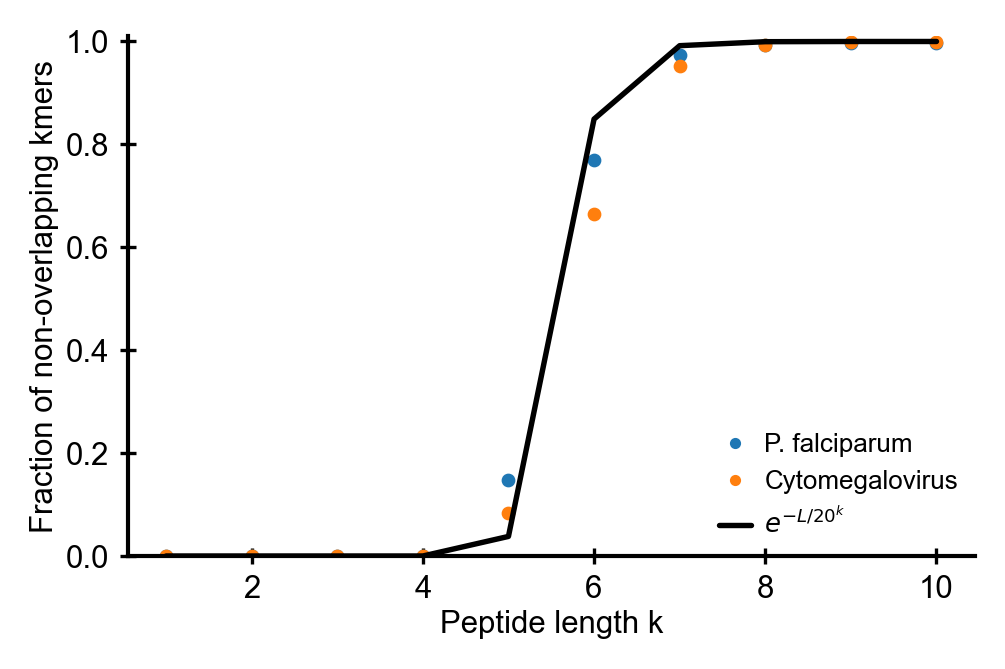

In [14]:
n = len(set_human)

fig, ax = plt.subplots()
ax.plot(ks, fractions_malaria, 'o', label='P. falciparum')
ax.plot(ks, fractions_cmv, 'o', label='Cytomegalovirus')
ax.plot(ks, np.exp(-n/20**ks), '-', color='k', label='$e^{-L/20^k}$')
ax.set_ylabel('Fraction of non-overlapping kmers')
ax.set_xlabel('Peptide length k')
ax.legend(loc='lower right')
ax.set_ylim(0.0, 1.01)
fig.tight_layout()
fig.savefig('classification_overlap.png')

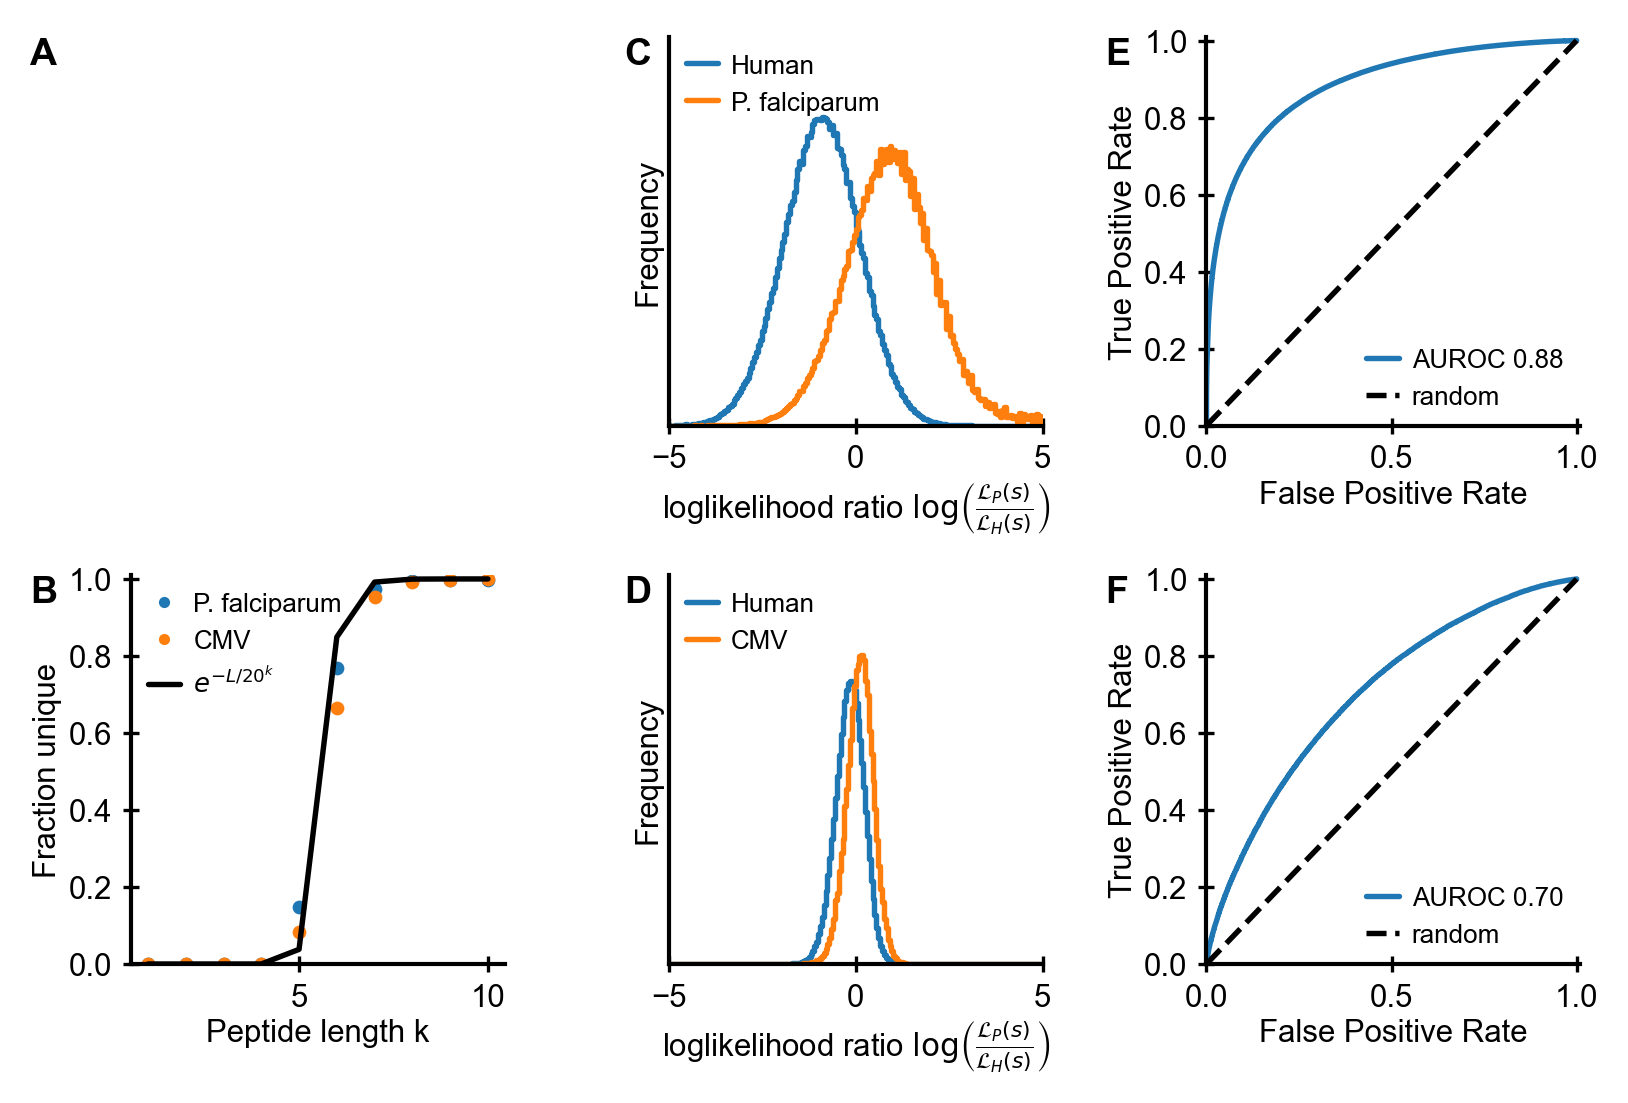

In [15]:
fig, axes = plt.subplots(figsize=(5.5, 3.75), ncols=3, nrows=2)

ax = axes[0, 0]
ax.axis('off')

ax = axes[1, 0]
ax.plot(ks, fractions_malaria, 'o', label='P. falciparum')
ax.plot(ks, fractions_cmv, 'o', label='CMV')
ax.plot(ks, np.exp(-n/20**ks), '-', color='k', label='$e^{-L/20^k}$')
ax.set_ylabel('Fraction unique')
ax.set_xlabel('Peptide length k')
ax.legend(loc='upper left')#, bbox_to_anchor=(0.0, 1.1))
ax.set_ylim(0.0, 1.01)

label_dict = {
              'Malaria': 'P. falciparum',
              'CMV' : 'CMV'
             }
for i, pathogen in enumerate(['Malaria', 'CMV']):
    
    data = all_data[pathogen]
    logp_hh, logp_pp, logp_hp, logp_ph = data['logp_hh'], data['logp_pp'], data['logp_hp'], data['logp_ph']
    
    ax = axes[i, 1]
    plot_histograms([logp_hp-logp_hh, logp_pp-logp_ph], ['Human', label_dict[pathogen]],
                    xmin=-5, xmax=5, ax=ax, nbins=200)
    ax.set_xlabel(r'loglikelihood ratio $\log \left( \frac{\mathcal{L}_P(s)}{\mathcal{L}_H(s)} \right)$')
    ax.set_yticks([])
    ax.set_ylabel('Frequency')
    ax.set_xlim(-5, 5)
    ax.set_ylim(0.0)
    ax.set_ylim(top=ax.get_ylim()[1]*1.2)
    ax.legend(loc='upper left')

    ax = axes[i, 2]
    ax.plot(data['fpr'], data['tpr'], label='AUROC %0.2f' % data['roc_auc'])
    ax.plot([0, 1], [0, 1], color='k', linestyle='--', label='random')
    ax.set_xlim(0.0, 1.01)
    ax.set_ylim(0.0, 1.01)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    

label_axes(axes[:, 1].flatten(), xy=(-0.12, 1.0), labels='CD')
label_axes(axes[:, (0, 2)].flatten(), xy=(-0.27, 1.0), labels='AEBF')
fig.tight_layout()

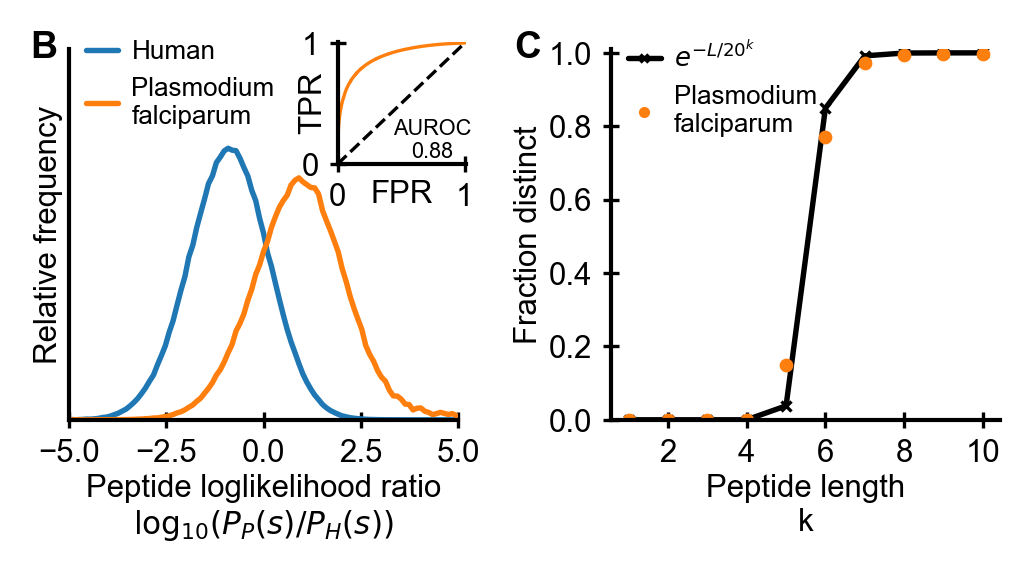

In [16]:
fig, axes = plt.subplots(figsize=(3.5, 2.0), ncols=2)

pathogen = 'Malaria'
    
data = all_data[pathogen]
logp_hh, logp_pp, logp_hp, logp_ph = data['logp_hh'], data['logp_pp'], data['logp_hp'], data['logp_ph']

ax = axes[0]
plot_histograms([logp_hp-logp_hh, logp_pp-logp_ph], ['Human', 'Plasmodium\nfalciparum'],
                xmin=-5, xmax=5, ax=ax, nbins=100, step=False)
ax.set_xlabel('Peptide loglikelihood ratio\n'+r'$\log_{10} \left(P_P(s) / P_H(s) \right)$')
ax.set_yticks([])
ax.set_ylabel('Relative frequency')
ax.set_xlim(-5, 5)
ax.set_ylim(0.0)
ax.set_ylim(top=ax.get_ylim()[1]*1.3)
ax.legend(loc='upper left', bbox_to_anchor=(0.0, 1.07))

ax = axes[0].inset_axes(bounds=(0.69, 0.69, 0.33, 0.33))
ax.plot(data['fpr'], data['tpr'], color=colors[1], label='AUROC %0.2f' % data['roc_auc'], lw=.8)
ax.plot([0, 1], [0, 1], color='k', linestyle='--', label='random', lw=.8)
ax.text(1.05, 0.05, 'AUROC\n%0.2f' % data['roc_auc'], fontsize='xx-small',
        multialignment='center', ha='right')
ax.set_xlim(0.0, 1.01)
ax.set_ylim(0.0, 1.01)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.xaxis.set_label_coords(0.5, -0.13)
ax.yaxis.set_label_coords(-0.08, 0.5)

ax = axes[1]
ax.plot(ks, np.exp(-n/20**ks), '-x', color='k', label='$e^{-L/20^k}$')
ax.plot(ks, fractions_malaria, 'o', color=colors[1], label='Plasmodium\nfalciparum')
ax.set_ylabel('Fraction distinct')
ax.set_xlabel('Peptide length\nk')
ax.legend(loc='upper left', bbox_to_anchor=(0.0, 1.07))
ax.set_ylim(0.0, 1.01)
ax.set_xticks(np.arange(2, 11, 2))
ax.set_yticks(np.arange(0.0, 1.1, 0.2))


label_axes(axes[0], labels='B', xy=(-0.1, 1.05))
label_axes(axes[1], labels='C', xy=(-0.25, 1.05))
fig.tight_layout()
fig.savefig(figuredir+'classifier.svg')